# Final Project Report
### EM 212: Applied Data Science
### Alexander Christenson

## Executive Summary

Bitcoin has swept the media recently. In the past several years the cryptocurrency has undergone massive fluctuations in price, but there is no intrinsic value to the product. Due to this, I believe bitcoin offers a great opportunity to analyze how the changes in the price are driven by mass psychological trends. How do people view the changes in price and is there a way the future movements can be predicted?

## Overview

This analysis is broken into four parts:
1. Introduction and Description of Data
2. Exploratory Data Analysis and Data Cleaning
3. Model of Data
4. Conclusion

## Introduction and Data Description

Bitcoin is a cryptocurrency. A cryptocurrency is a digital token that can be exchange for goods or service. The key differences between cryptocurrencies and physical (fiat) currencies are:

* Cryptocurrencies are decentralized. 
    * This means that there is no central source of production and decision making regarding the management of the currency. Miners will exchange computational power solving complex numerical puzzles to help keep track of all the transactions, and are rewarded with units of the currency. They can then sell the currrency to exchanges who trade it for fiat currencies, or exchange it with another party for some good or service.

* Fiat currencies are backed by the governments that issue them, cryptocurrencies are not.
    * This makes pricing for cryptocurrencies purely driven by supply and demand.
    
What I want to do is I want to take advantage of this opportunity of not having any controlling factors on the asset to see how supply and demand build off of each other. In this case the price of the asset can serve as a solid proxy for how cycles of supply and demand function based off of how people speculate on the relationship between past and future growths.

The datasets I will be using for this project are from two sources:
1. [Gemini](https://gemini.com/)
2. [DataHub](https://datahub.io/cryptocurrency/bitcoin)

A datasheet for the Gemini dataset is in the same github repository as this project code. The link to the repository is [here](https://github.com/alch5436/applied_ds/tree/alch5436Proj2/Alex%20Project%202).

A brief description of the data:
1. Gemini is a cryptocurrency exchange. They provide liquidity in the market, meaning they hold bitcoins to sell to clients for fiat currency, and hold fiat to purchase bitcoin from people willing to sell. They collect data on all of the transactions made on the platform, and have made public the historical prices of the currency. The prices are Unix timestamped. The prices come in four formats. This data has been collected in one minute increments from October 2015-April 2019 when they discontinued access to the data.
    1. Open - The price the exchange opened at. Since the exchange is open 24/7, the price here is the price at midnight, UTC.
    2. Low - The low price for a trading cycle, 0:00-23:59 UTC.
    3. High - The high price for a trading cycle, 0:00-23:59 UTC.
    4. Close - The price at the end of a trading cycle, 23:59 UTC.

2. DataHub - DataHub is a provider of datasets for datascientists, and hosts datasets ranging from employment in developing countries to weather data for climate change analysis. The data they have is for sale, however, they offer some sets for free and this is one. This dataset is relatively similar to the other one and I will be using it in the same context/pulling the information to verify the results of my analysis against a different data source. Additionally, this could account for extreme fluctuations in price when the exchanges had low volume to exchange or matched eccentric buyers/sellers. The DataHub website has a detailed description of the bitcoin dataset [here](https://datahub.io/cryptocurrency/bitcoin#data-sources-and-methodology).

In [1]:
# Importing libraries from the EDA example
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
# Pulling the dataset for bitcoin prices
BTC_trans = pd.read_csv("https://datahub.io/cryptocurrency/bitcoin/r/bitcoin.csv")

In [3]:
# Importing the data from exchange
bitcoin_price_2015 = pd.read_csv("Project_Data/gemini_BTCUSD_2015_1min.csv",skiprows=1)
bitcoin_price_2016 = pd.read_csv("Project_Data/gemini_BTCUSD_2016_1min.csv",skiprows=1)
bitcoin_price_2017 = pd.read_csv("Project_Data/gemini_BTCUSD_2017_1min.csv",skiprows=1)
bitcoin_price_2018 = pd.read_csv("Project_Data/gemini_BTCUSD_2018_1min.csv",skiprows=1)
bitcoin_price_2019 = pd.read_csv("Project_Data/gemini_BTCUSD_2019_1min.csv",skiprows=1)

In [4]:
# Concatonate the yearly data together
BTC_price = [bitcoin_price_2019,bitcoin_price_2018,bitcoin_price_2017,bitcoin_price_2016,bitcoin_price_2015]
BTC_price = pd.concat(BTC_price).reset_index(drop=True)

## Exploratory Data Analysis and Data Cleaning

We will start by looking at the head of the merged dataset. We want to confirm we got what we have been looking for.

In [5]:
BTC_price.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1555545780000,2019-04-18 00:03:00,BTCUSD,5229.40,5229.40,5229.40,5229.40,0.000000
1,1555545720000,2019-04-18 00:02:00,BTCUSD,5230.47,5230.47,5229.40,5229.40,2.202891
2,1555545660000,2019-04-18 00:01:00,BTCUSD,5245.00,5245.00,5230.47,5230.47,0.232941
3,1555545600000,2019-04-18 00:00:00,BTCUSD,5246.10,5246.10,5229.74,5245.00,50.168412
4,1555545540000,2019-04-17 23:59:00,BTCUSD,5231.69,5246.10,5231.69,5246.10,20.000000


Now that we know our data is at least of roughly the right thing we are looking for, let's poke a little deeper.

In [6]:
BTC_price.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06,1.812109e+06
mean,2.577871e+11,3.753850e+03,3.755548e+03,3.752100e+03,3.753854e+03,2.950303e+00
std,5.744834e+11,3.759127e+03,3.762015e+03,3.756117e+03,3.759126e+03,2.347867e+01
min,1.444312e+09,0.000000e+00,2.425000e+02,0.000000e+00,2.360000e+02,0.000000e+00
25%,1.471493e+09,6.179800e+02,6.179800e+02,6.179800e+02,6.179800e+02,0.000000e+00
50%,1.498675e+09,2.550130e+03,2.550440e+03,2.550000e+03,2.550130e+03,1.203491e-02
75%,1.525856e+09,6.407780e+03,6.408540e+03,6.406760e+03,6.407780e+03,1.138193e+00
max,1.555546e+12,1.999900e+04,1.999900e+04,1.999070e+04,1.999900e+04,8.264463e+03


The min and the max for the timestamps are off by a massive scale. I don't have a very intuitive sense of what a unix timestamp is, so let's check for missing data and look at that later. For reference, a unix timestamp is a count up from 0:00 UTC, January 1, 1970 in seconds, not counting leap seconds. More info can be found on the wikipedia page [here](https://en.wikipedia.org/wiki/Unix_time)

In [7]:
bitcoin_NaN_ratio = BTC_price.isnull().sum()/len(BTC_price)
bitcoin_NaN_ratio

Unix Timestamp    0.0
Date              0.0
Symbol            0.0
Open              0.0
High              0.0
Low               0.0
Close             0.0
Volume            0.0
dtype: float64

Looks like we're not missing any values in our dataset.

Lets see how much data we're working with.

In [8]:
print(len(BTC_price))

1812109


That's a lot of data, let't try visualizing the price over time to see what is happening with the data.

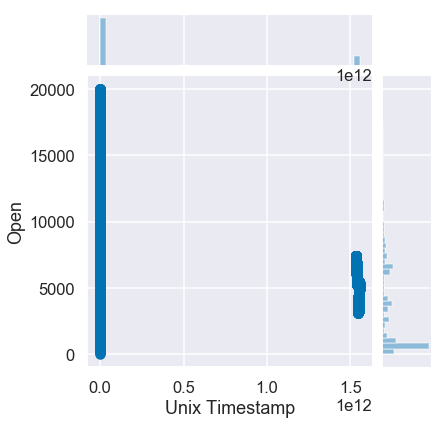

In [9]:
sns.jointplot(x=BTC_price['Unix Timestamp'],y=BTC_price['Open'])

This doesn't look quite right. There are a lot of data entries, but not enough to account for the variation in min/max on the unix times. Let's look at the distribution on them.

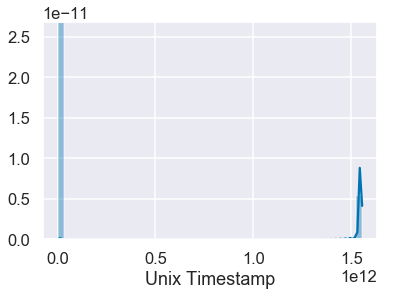

In [10]:
sns.distplot(BTC_price["Unix Timestamp"])

There seems to be a bifarcation of the time stamps. Let's see how big they are.

In [11]:
left_data = BTC_price[BTC_price["Unix Timestamp"]<0.2e+12]
print(len(left_data))

1511299


In [12]:
right_data = BTC_price[BTC_price["Unix Timestamp"]>1.2e+12]
print(len(right_data))

300810


In [13]:
print(len(BTC_price)-len(left_data)-len(right_data))

0


So the data is completely separated into two categories. Let's try to convert them to a more human readable format.

In [14]:
from datetime import datetime # Import the libraries to convert UNIX to readable time
ts_left = int(left_data['Unix Timestamp'].iloc[0])
print(datetime.utcfromtimestamp(ts_left).strftime('%Y-%m-%d %H:%M:%S'))

2018-08-23 01:58:00


In [15]:
#ts_right = int(right_data['Unix Timestamp'].iloc[0])
#print(datetime.utcfromtimestamp(ts_right).strftime('%Y-%m-%d %H:%M:%S'))

When I tried to check the data on the right, I got an error about the time not happening yet. Let's see exactly how far off the data on the right is. We don't want to necessarily throw this away because the data could have a systematic error we can correct for.

In [16]:
print(right_data['Unix Timestamp'].iloc[0])
print(left_data['Unix Timestamp'].iloc[0])

1555545780000
1534989480


It looks like the left side of the data is a factor of 1000 off from the data on the right. Since the data is so tightly clustered to these regions, lets try fixing the points that are so far off by scaling the greater ones since they translate to times that are in the future.

It looks like for the years 2018 and 2019 the unix timestamps are off by a factor of 1000 based off of the differences between the previous years. Lets try fixing this and replotting the price.

In [17]:
BTC_price['Unix Timestamp'][BTC_price['Unix Timestamp']>1e+12] = BTC_price['Unix Timestamp'][BTC_price['Unix Timestamp']>1e+12]/1000

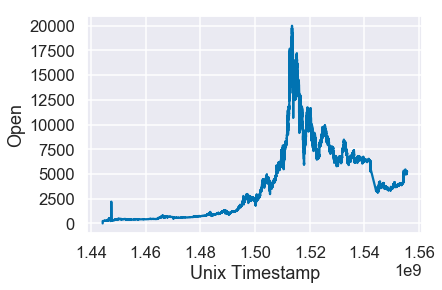

In [18]:
sns.lineplot(x=BTC_price['Unix Timestamp'],y=BTC_price['Open'])
sns.set(rc={'figure.figsize':(30,10)})

Now this data looks like it's following a more realistic trend. Lets compare this chart to existing charts, like this one from CoinMarketCap:
![alt text](Project_Data/chart.png "Logo Title Text 1")

The portion of the chart we need to pay attention to is the one highlighted with blue below.

The CoinMarketCap graph is made from data taken every day, compared to our data which is collected every minute, and comes from its own exchange. This exchange could have been manipulated by large transaction volumes after it recently opened or have seen spikes in demand at a particular minute, or could have been errors in the data. Let's zoom in a little on this section.

In [19]:
# This process is very inefficient, taking a long time for my computer to process,
# and is unecessary to building a model to give us insights about the data.
# For these reasons I am commenting out this section.
#def convertToHuman(a):
#    return datetime.utcfromtimestamp(a).strftime('%Y-%m-%d %H:%M:%S')
#
#BTC_price['Human Timestamp'] = BTC_price['Unix Timestamp'].apply(convertToHuman)
#sns.lineplot(x=BTC_price['Human Timestamp'],y=BTC_price['Open'])

In [20]:
subset = BTC_price[(BTC_price['Unix Timestamp']<1.448e+9)&(BTC_price['Unix Timestamp']>1.447e+9)]

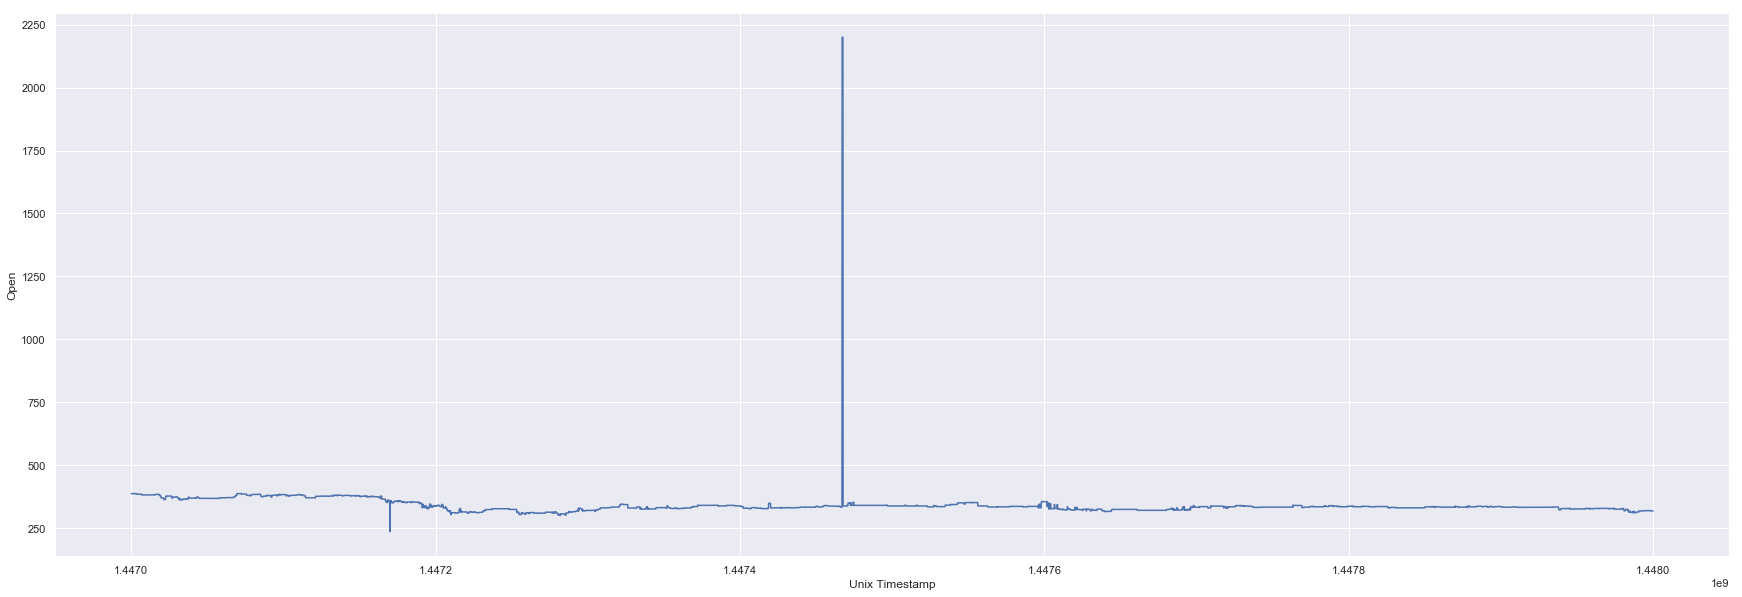

In [21]:
sns.lineplot(x=subset['Unix Timestamp'],y=subset['Open'])

There's definitely a spike in value here. Let's see how long it lasts.

In [22]:
spike = subset[subset['Open']>500]

In [23]:
len(spike)

10

Since the data is in minutes, and the length is ten, this means the spike only lasted for 10 minutes. Let's do a log transformation on the data before smoothing it.

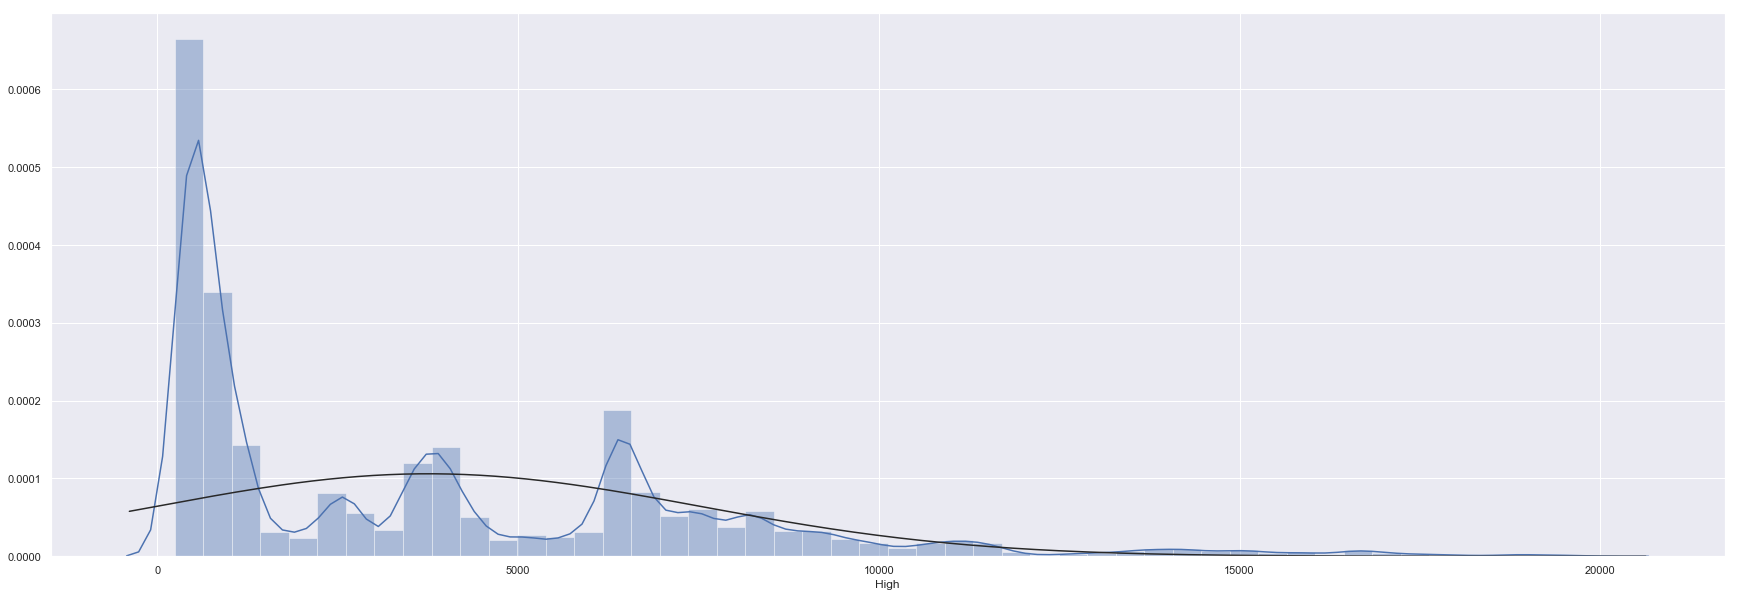

In [24]:
sns.distplot(BTC_price['High'], fit=stats.norm)

This data looks like it's pretty spread apart in magnitude. Lets take a look at the Q-Q plot.

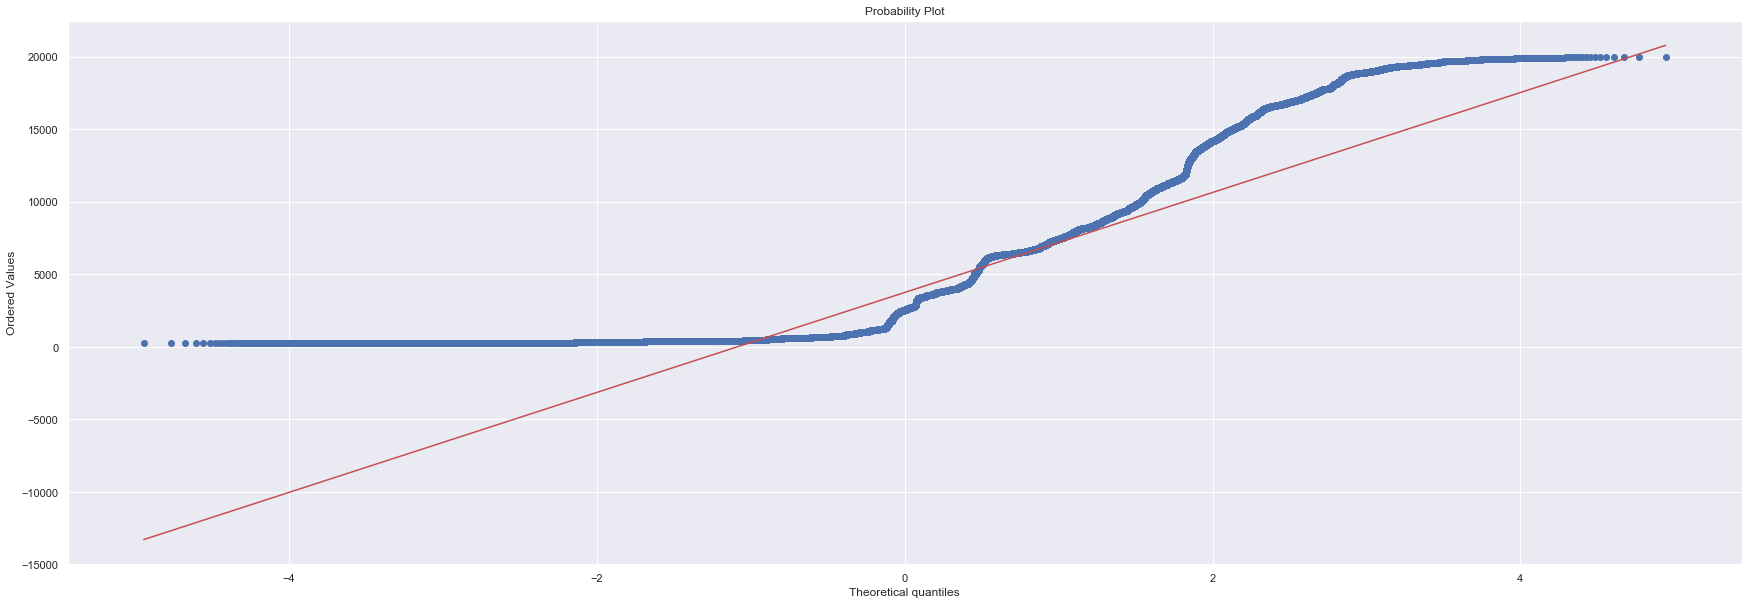

In [25]:
res = stats.probplot(BTC_price['High'], plot=plt)
plt.show()

Let's do a log transformation to smooth this out a bit.

In [26]:
BTC_price['Open'] = np.log1p(BTC_price['Open'])
BTC_price['Close'] = np.log1p(BTC_price['Close'])
BTC_price['High'] = np.log1p(BTC_price['High'])
BTC_price['Low'] = np.log1p(BTC_price['Low'])

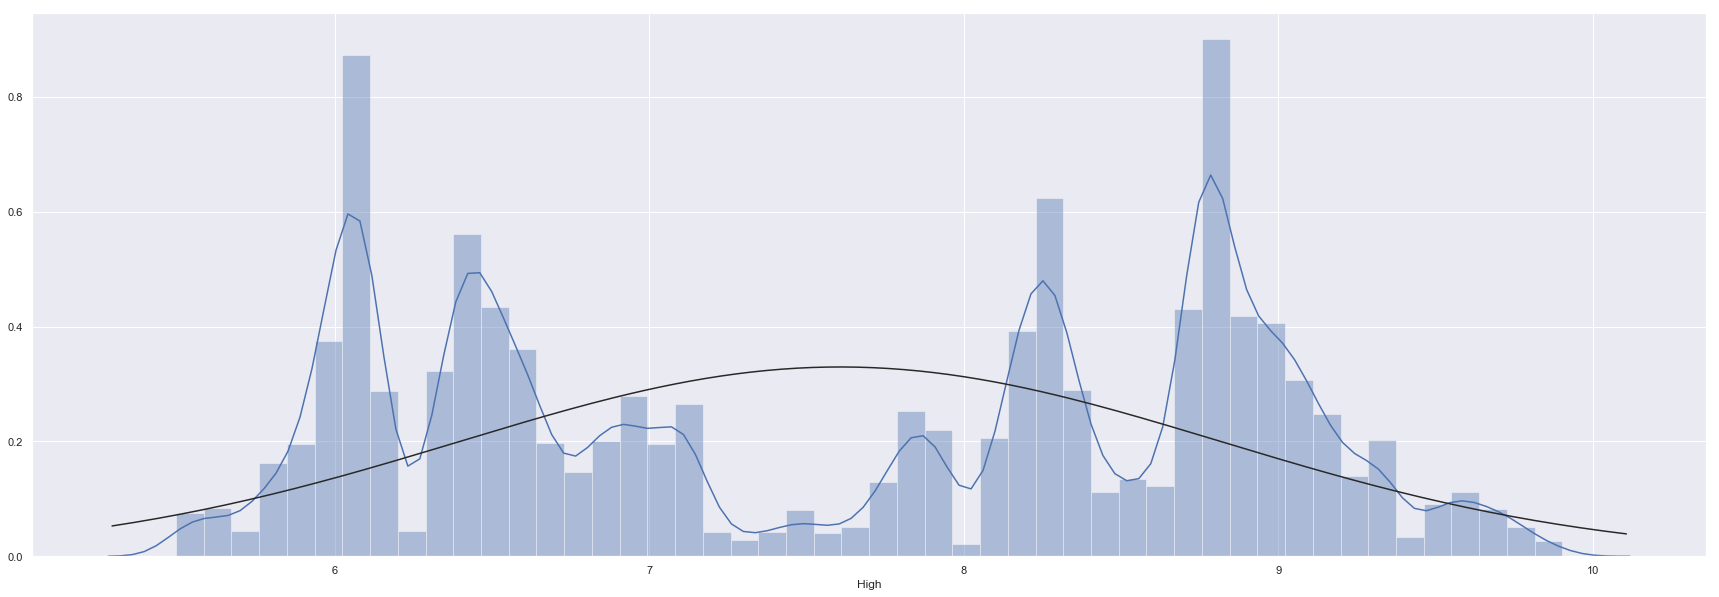

In [27]:
sns.distplot(BTC_price['High'], fit=stats.norm)

This distribution is still very wide, but this makes sense from a financial analysis perspective. Bitcoin is considered a very risky asset, and so the variance of its price is correspondingly high.

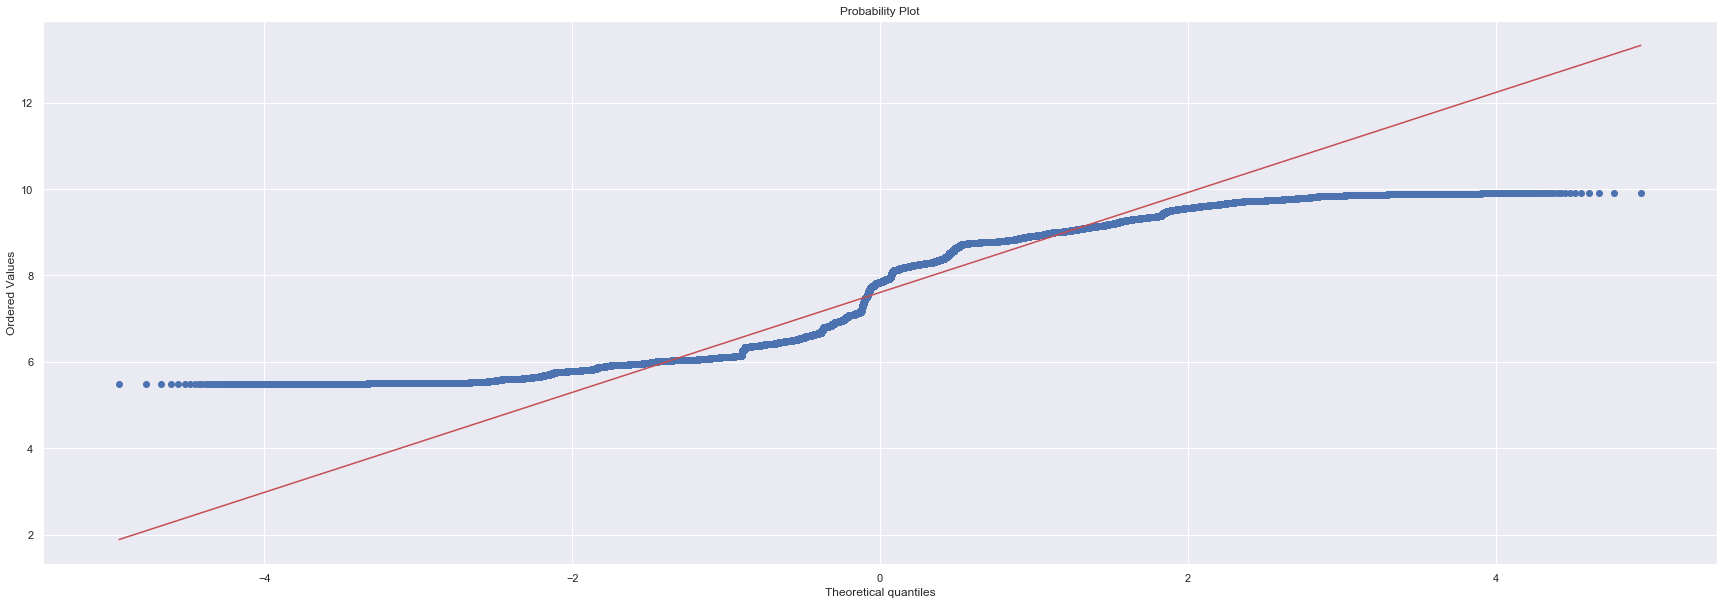

In [28]:
res = stats.probplot(BTC_price['High'], plot=plt)
plt.show()

In my (limited) experience using q-q plots I've used them to see how well data fits a normal distribution, and tried using a transformation to normalize it, because normally distributed data performs better in the regression models I have used. In this case the data looks like an arctan function. Lets try applying a tan tranformation just to see what happens.

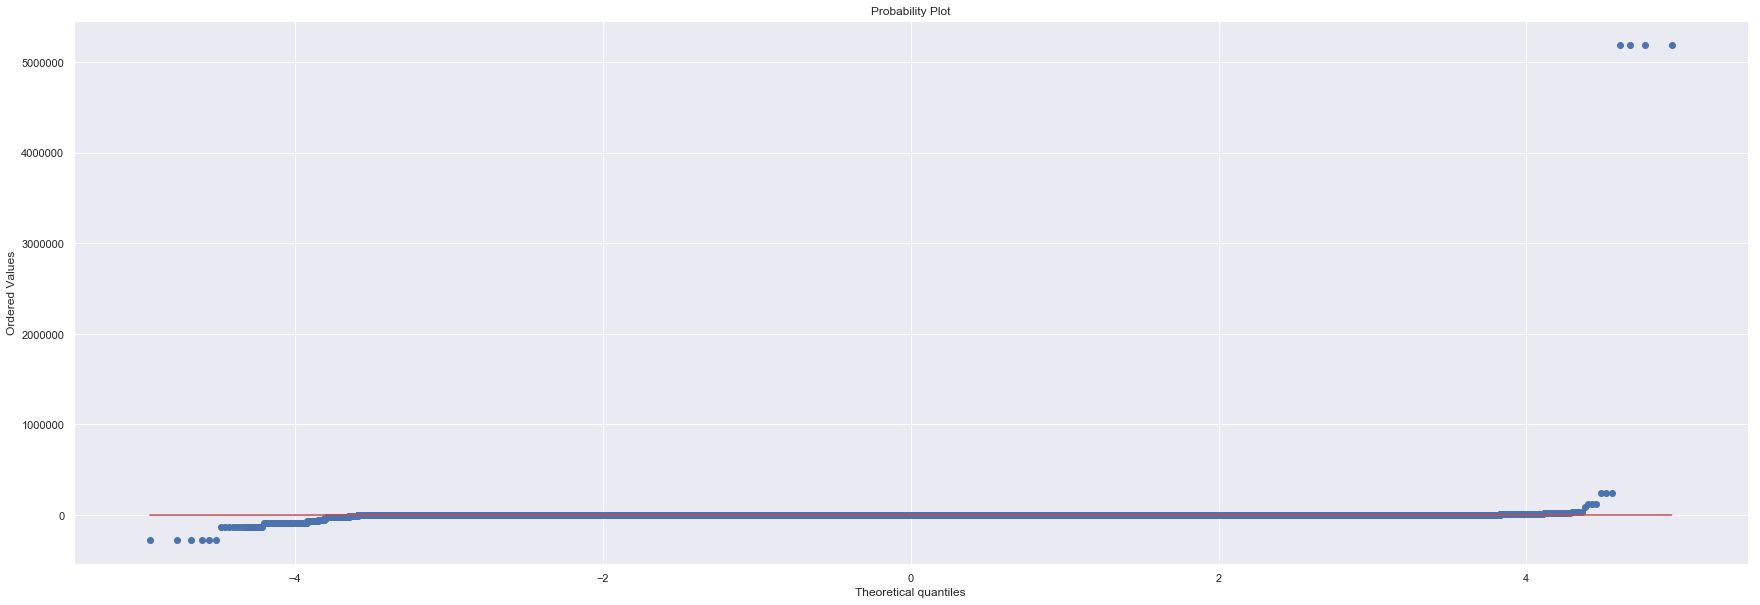

In [29]:
price = np.tan(BTC_price['High'])
res = stats.probplot(price, plot=plt)
plt.show()

There's some outliers here in the q-q plot. I don't have a deep enough understanding of the statistics behind the q-q plots to justify removing the data because of this transformation. I think it could still be valuable in understanding the data set. I'll keep the log transformation because I feel that does add some value to the analysis.

## Model
First, I'm going to run a basic linear regression of the data to see if there is a macro trend to the set.

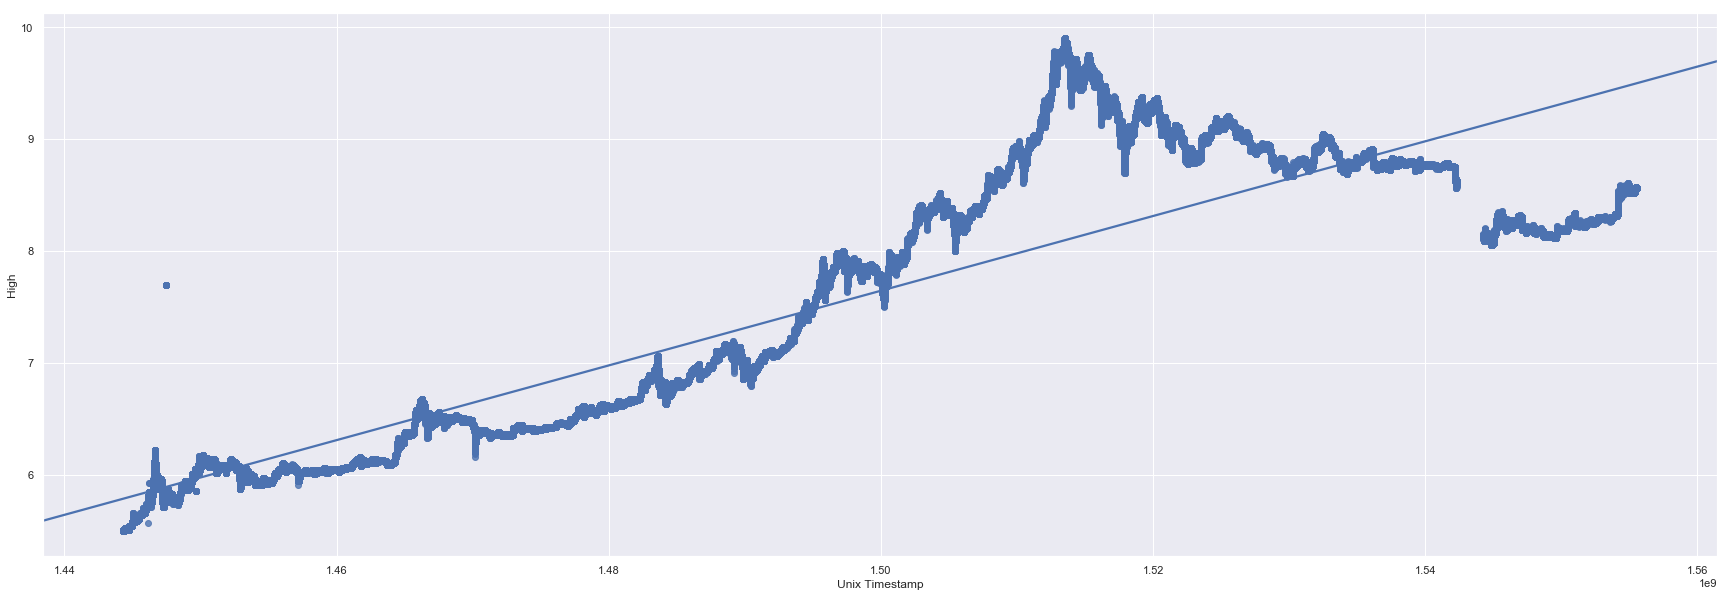

In [30]:
sns.regplot(x="Unix Timestamp",y="High",data=BTC_price,ci=None)

This linear regression doesn't look too bad. It definitely does not fit perfectly, but I think it gives at least some insight into the general trend that the price is moving in.

Now that we can see a macro trend of the dataset, lets try to look at the logistic regression and see how the results compare.

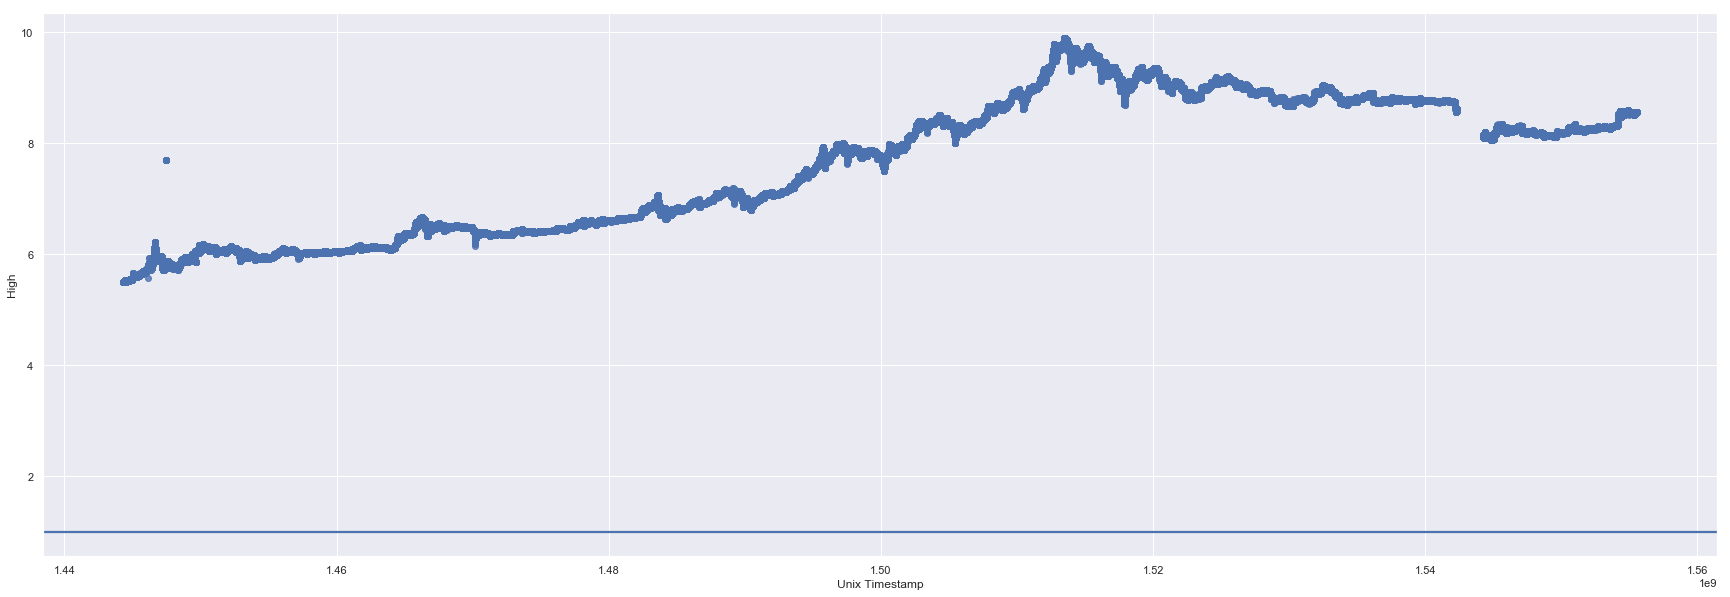

In [32]:
#sns.regplot(x="Unix Timestamp",y="High",data=BTC_price,ci=None,logistic=True)

The logistic regression turned out to be useless. It didn't tell anything about trends in the data, and was very computationally expensive so I am going to comment it out.

Now that we've done some regression on the data, let's try using a more sophisticated model called ARIMA. ARIMA stands for AutoRegressive (AR) Integrated (I) Moving Average (MA). To do this I will use a function from statsmodels. The function takes in three values,
1. p - how many previous datapoints to take into account
2. q - a scaling factor for the differences between the data points
3. d - how big to make the moving average window. For this case I will set this to zero, because we want to ignore the averages in the analysis to just look at how the changes are related to the previous ones.

In order to figure out how many of the previous data points we should use we need to see how strongly the data points are related to each other relative to time.

KeyboardInterrupt: 

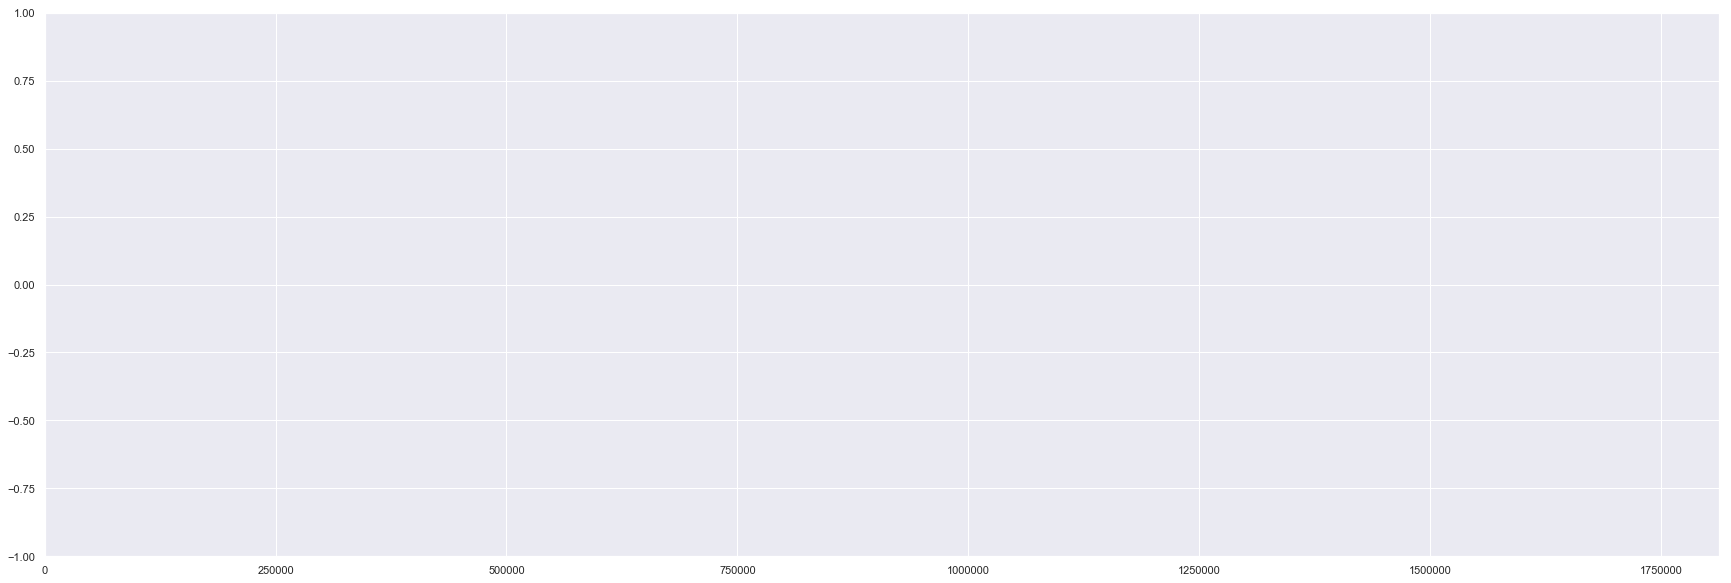

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

#autocorrelation_plot(BTC_price['High'])

## Conclusions

I haven't been able to get the autocorrelation up and running. I would love to be able to do this as future work for the project. For now, this big takeaway from the assignment is the macro trend that is visible by looking at the linear regression in the context of looking for a long term changes. It seems that people are responding over a long term to the supply and demand price increases, with short spikes in demand still having a big influence long term.